# QUE 01: GMM

In [3]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.distributions as dist
import matplotlib.pyplot as plt
data_path = "./afhq"
batch_size = 64
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
dataset = ImageFolder(root=data_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Number of batches: {len(data_loader)}")
print(f"Total number of images: {len(dataset)}")


FileNotFoundError: Found no valid file for the classes MNIST. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 16130
    Root location: C:\Users\Gaurav Talekar\afhq
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [215]:
data_loader

In [ ]:
# # Initialize a 10x10 subplot grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

# # Iterate through the DataLoader to display 100 images in the grid
for i, batch in enumerate(data_loader):
    
    image, _ = batch
    ax = axs[i // 10, i % 10]  # Get the appropriate subplot
    ax.imshow(image[0].permute(1, 2, 0).numpy())  # Assuming batch size is 1
    
    ax.axis('off')  # Turn off axis labels and ticks
    
    if i == 99: 
        
        break

plt.subplots_adjust(wspace=0.1, hspace=0.5)  # Adjust spacing between subplots
plt.show()

In [29]:
class GMM(nn.Module):
    
    def __init__(self, num_mixtures, num_features):
        
        super(GMM, self).__init__()
        self.num_mixtures = num_mixtures
        self.num_features = num_features
        self.means = nn.Parameter(torch.randn(num_mixtures, num_features))
        covariances = []
        for i in range(num_features):
            cov_matrix = nn.Parameter(torch.eye(num_features) * 0.01)

            covariances.append(cov_matrix)
        self.covariances = nn.Parameter(torch.stack(covariances, dim=0))
        self.mixing_weights = nn.Parameter(torch.ones(num_mixtures) / num_mixtures)
        
    def expectation(self, data):
        num_points = data.shape[0]  
        num_mixtures = self.num_mixtures
        posteriors = torch.zeros(num_points, num_mixtures)
        for i in range(num_points):
            for j in range(num_mixtures):
                multivariate_normal = dist.MultivariateNormal(self.means[j], covariance_matrix=self.covariances[j])
                likelihood = torch.exp(multivariate_normal.log_prob(data[i]))
                posteriors[i, j] = self.mixing_weights[j] * likelihood
            posteriors[i] /= torch.sum(posteriors[i])
        
        return posteriors

    
    
    def maximization(self, data, posteriors):
        num_points, num_mixtures = posteriors.size()
        self.mixing_weights.data = posteriors.sum(dim=0) / num_points
        for j in range(num_mixtures):
            weighted_sum = torch.sum(posteriors[:, j].unsqueeze(1) * data, dim=0)
            self.means.data[j] = weighted_sum / posteriors[:, j].sum()
        
        for j in range(num_mixtures):
            weighted_diff = data - self.means[j]
            weighted_cov = torch.mm((weighted_diff * posteriors[:, j].unsqueeze(1)).t(), weighted_diff)

            self.covariances.data[j] = weighted_cov / posteriors[:, j].sum()

    def log_likelihood(self, data):
        num_samples, num_features = data.shape
        num_mixtures = self.means.shape[0]
        likelihoods = torch.zeros(num_samples)
        for i in range(num_samples):
            log_likelihood = 0
            for j in range(num_mixtures):
                mvn = dist.MultivariateNormal(self.means[j], covariance_matrix=self.covariances[j])
                log_likelihood += torch.log(self.mixing_weights[j]) + mvn.log_prob(data[i])
            likelihoods[i] = log_likelihood
        return torch.sum(torch.logsumexp(likelihoods, dim=0))
 

In [30]:
# Create an instance of the GMM model
num_mixtures = 3  # You can adjust this number as needed
num_features = 16 * 16 * 3
gmm = GMM(num_mixtures, num_features)

# Define your optimizer
optimizer = torch.optim.Adam(gmm.parameters(), lr=0.01)

# Training loop
num_iterations = 100  # Adjust the number of iterations as needed
for iteration in range(num_iterations):
    for batch in data_loader:
        data = batch[0].view(batch[0].size(0), -1)
        # E-step: Calculate responsibilities
        posteriors = gmm.expectation(data)
    
        # M-step: Update parameters
        gmm.maximization(data, posteriors)
    
        # Calculate and print the log likelihood
        log_likelihood = gmm.log_likelihood(data)
        print(f"Iteration {iteration + 1}/{num_iterations}, Log Likelihood: {log_likelihood.item()}")


ValueError: Expected parameter loc (Tensor of shape (768,)) of distribution MultivariateNormal(loc: torch.Size([768]), covariance_matrix: torch.Size([768, 768])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<ExpandBackward0>)

# QUE 02:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


ModuleNotFoundError: No module named 'tqdm'

In [5]:
transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = ImageFolder(root="./afhq/train", transform=transform)
val_dataset = ImageFolder(root="./afhq/val", transform=transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)



In [6]:
BATCH_SIZE = 128
IMAGE_SIZE = 28
LATENT_DIM = 64
NUM_EPOCHS = 50
NUM_CLASSES = 3

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.SELU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.SELU(),
            nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.SELU(),
            nn.Linear(512, LATENT_DIM * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 512),
            nn.SELU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.SELU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.SELU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = x[:, :LATENT_DIM], x[:, LATENT_DIM:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [12]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Likelihood term (MSE)
    MSE = nn.MSELoss(reduction='sum')
    mse_loss = MSE(recon_x, x)

    # KL divergence term
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combined loss
    loss = mse_loss +  beta*kld_loss  

    return loss, mse_loss, kld_loss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [14]:
beta = 1  # Adjust beta as needed
vae.train()
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss, mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Total Loss: {loss.item() / len(data)}, MSE Loss: {mse_loss.item() / len(data)}, KL Loss: {kld_loss.item() / len(data)}")

Epoch [1/50] Total Loss: 68.75404759457237, MSE Loss: 54.3405183490954, KL Loss: 14.41352763928865
Epoch [2/50] Total Loss: 65.07309441817434, MSE Loss: 49.84205386513158, KL Loss: 15.231040553042764
Epoch [3/50] Total Loss: 66.91690866570724, MSE Loss: 50.007173237047695, KL Loss: 16.90973703484786
Epoch [4/50] Total Loss: 59.24421772203947, MSE Loss: 43.231252569901315, KL Loss: 16.0129683645148
Epoch [5/50] Total Loss: 58.64515445106908, MSE Loss: 42.5341796875, KL Loss: 16.11097476356908
Epoch [6/50] Total Loss: 60.970979389391445, MSE Loss: 44.77857730263158, KL Loss: 16.19240208675987
Epoch [7/50] Total Loss: 57.0038420024671, MSE Loss: 40.82613332648026, KL Loss: 16.177711888363486
Epoch [8/50] Total Loss: 61.346872430098685, MSE Loss: 45.51474802117599, KL Loss: 15.83212601511102
Epoch [9/50] Total Loss: 66.16696006373355, MSE Loss: 49.694772820723685, KL Loss: 16.47218724300987
Epoch [10/50] Total Loss: 67.26055586965461, MSE Loss: 50.89135420949835, KL Loss: 16.36920326634457

In [15]:
from torchvision.utils import save_image

vae.eval()
with torch.no_grad():
    for i in range(10):
        z = torch.randn(128, LATENT_DIM).to(device)
        generated_images = vae.decode(z)
        save_image(generated_images.view(128, 3, 28, 28),  # Adjust the view operation
                   f"Generated_samples_{i}.png", nrow=10, normalize=True)







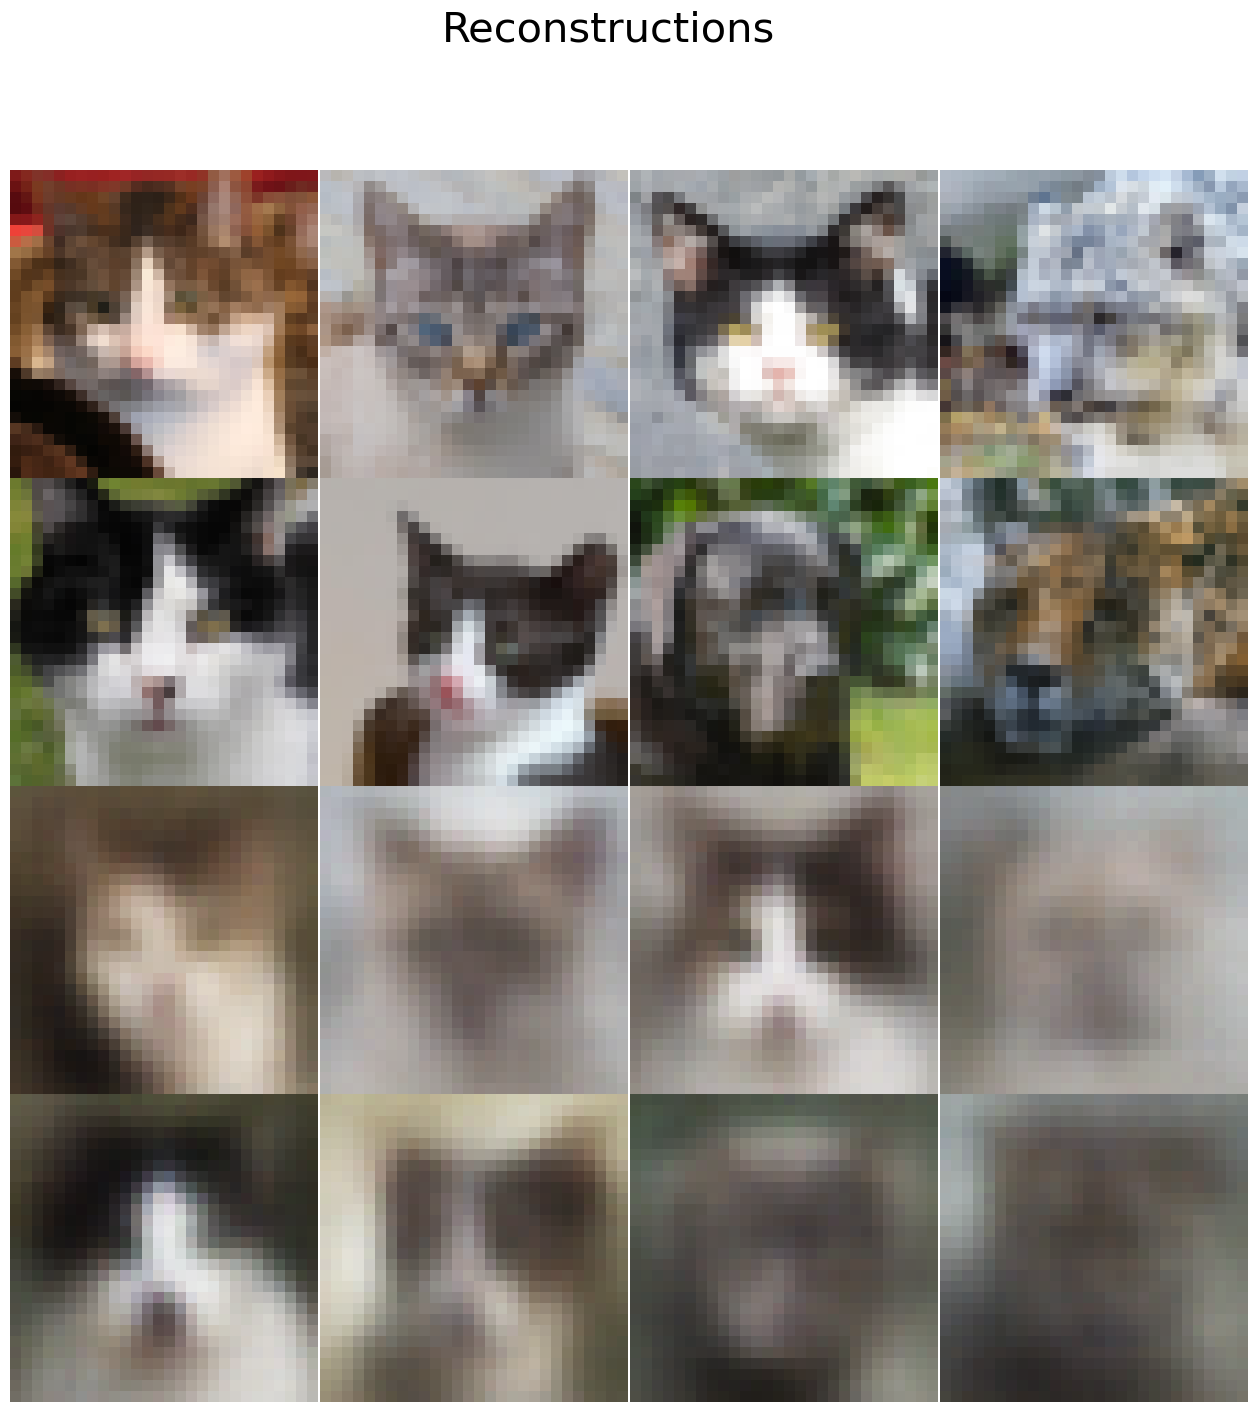

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(images, title, legend_fontsize=20):
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i, ax in enumerate(axes.flat):
        image = images[0][i].permute(1, 2, 0).cpu().detach().numpy()
        ax.imshow(np.clip(image, 0, 1))  # Ensure values are in the [0, 1] range
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title, fontsize=legend_fontsize)  # Set the fontsize for the legend
    plt.show()

# Load and display reconstructions
reconstruction_images = [torch.cat([data[:8].to(device), recon_batch[:8]]).cpu()]
plot_grid(reconstruction_images, "Reconstructions", legend_fontsize=30)  # Adjust the legend_fontsize as needed


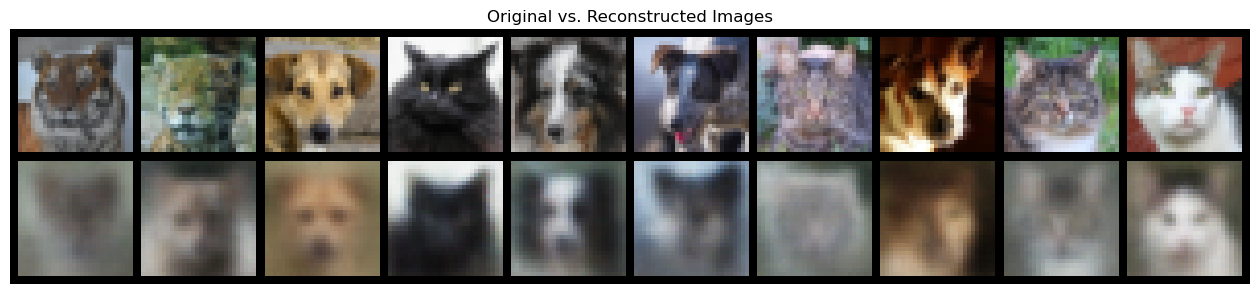

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to plot original and reconstructed images side by side
def plot_original_reconstructed(vae,val_dataloader, device):
    vae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_iter = iter(val_dataloader)
        data, _ = next(data_iter)
        data = data.to(device)
        
        # Reconstruct the data
        recon_batch, _, _ = vae(data)
        
        # Create a grid of original and reconstructed images
        combined_images = torch.cat([data[:10], recon_batch[:10]])
        
        # Plot the grid of images
        plt.figure(figsize=(16, 10))
        plt.axis("off")
        plt.title("Original vs. Reconstructed Images")
        plt.imshow(vutils.make_grid(combined_images, nrow=10, normalize=True).cpu().numpy().transpose(1, 2, 0))
        plt.show()

# Call the function to plot original and reconstructed images
plot_original_reconstructed(vae, val_dataloader, device)


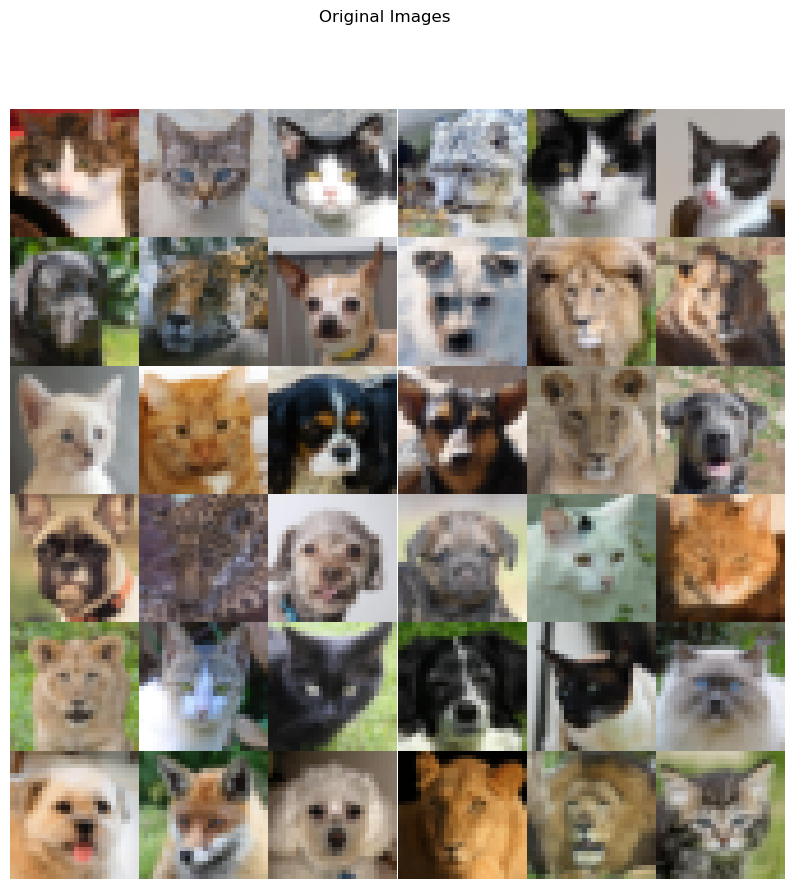

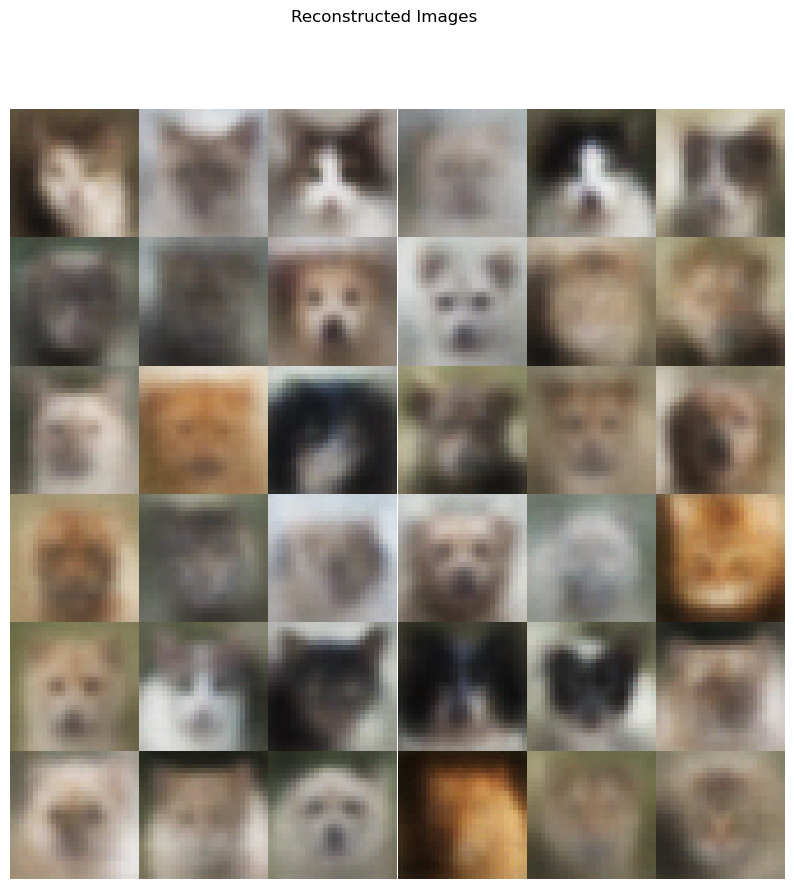

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(images, title):
    num_images = images.size(0)
    grid_size = int(np.sqrt(num_images))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    if grid_size == 1:  # Handle the case when grid size is 1x1
        axes = np.array([[axes]])
    
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            index = i * grid_size + j
            if index < num_images:
                image = images[index].detach().cpu().permute(1, 2, 0).numpy()
                ax.imshow(np.clip(image, 0, 1))
                ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    plt.show()

# Load and display the first 100 original images
plot_grid(data[:100], "Original Images")

# Load and display the first 100 reconstructed images
plot_grid(recon_batch[:100], "Reconstructed Images")



Epoch [1/50] Likelihood Loss: 24.066544382195723, KL Loss: 0.07327361483322947, Combined Loss: 24.13981869346217
Epoch [2/50] Likelihood Loss: 24.16194554379112, KL Loss: 0.0794543843520315, Combined Loss: 24.24140046772204
Epoch [3/50] Likelihood Loss: 21.854203073601973, KL Loss: 0.09104478986639726, Combined Loss: 21.945248252467106
Epoch [4/50] Likelihood Loss: 19.352992007606908, KL Loss: 0.09786165388006914, Combined Loss: 19.45085384971217
Epoch [5/50] Likelihood Loss: 17.7571732370477, KL Loss: 0.10192820272947613, Combined Loss: 17.8591019479852
Epoch [6/50] Likelihood Loss: 20.06194425884046, KL Loss: 0.10755548979106702, Combined Loss: 20.169499447471217
Epoch [7/50] Likelihood Loss: 16.468774092824834, KL Loss: 0.11049472658257735, Combined Loss: 16.579268606085527
Epoch [8/50] Likelihood Loss: 16.200625770970394, KL Loss: 0.11396814647473787, Combined Loss: 16.31459446957237
Epoch [9/50] Likelihood Loss: 16.209776225842926, KL Loss: 0.11625833260385614, Combined Loss: 16.3

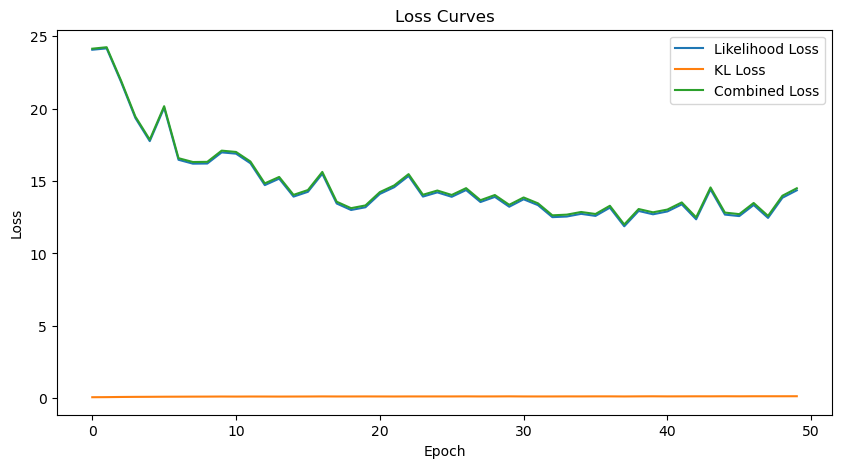

In [19]:
import matplotlib.pyplot as plt

# Initialize empty lists to store losses
likelihood_losses = []
kl_losses = []
combined_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        
        # Calculate likelihood loss
        mse_loss = nn.MSELoss(reduction='sum')(recon_batch, data)
        
        # Calculate KL divergence loss
        prior = torch.distributions.Normal(0, 1)
        posterior = torch.distributions.Normal(mu, logvar.exp().sqrt())
        kld_loss = torch.mean(torch.distributions.kl.kl_divergence(posterior, prior))
        
        # Combined loss
        loss = mse_loss + kld_loss * beta
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Store losses for this epoch
    likelihood_losses.append(mse_loss.item() / len(data))
    kl_losses.append(kld_loss.item() / len(data))
    combined_losses.append(loss.item() / len(data))

    # Print and save losses at the end of each epoch
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Likelihood Loss: {mse_loss.item() / len(data)}, KL Loss: {kld_loss.item() / len(data)}, Combined Loss: {loss.item() / len(data)}")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(likelihood_losses, label='Likelihood Loss')
plt.plot(kl_losses, label='KL Loss')
plt.plot(combined_losses, label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.grid(True)
plt.show()


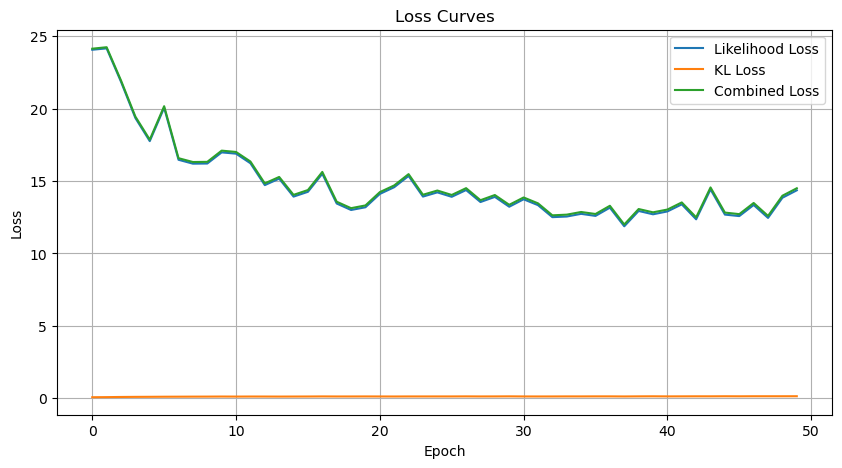

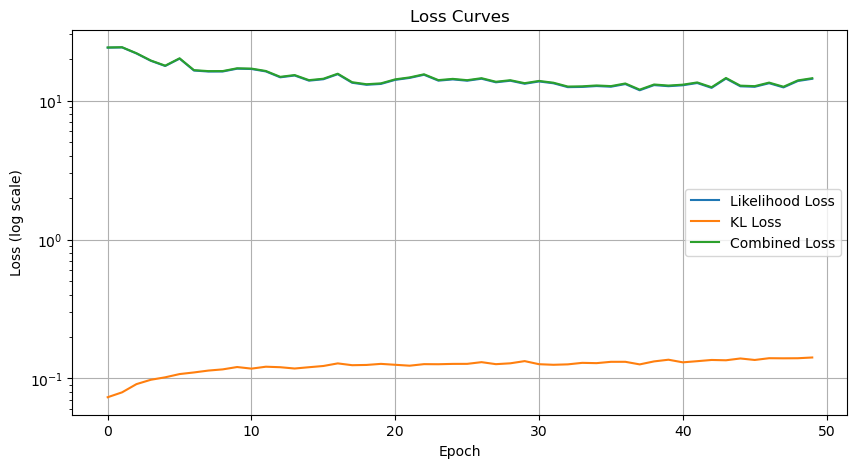

In [21]:
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(len(likelihood_losses)), likelihood_losses, label='Likelihood Loss')
plt.semilogy(np.arange(len(kl_losses)), kl_losses, label='KL Loss')
plt.semilogy(np.arange(len(combined_losses)), combined_losses, label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Loss Curves')
plt.grid(True)  


# CNN Classifier

In [37]:
torch.manual_seed(42)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image values to range [-1, 1]
])

# Load the dataset
train_dataset = ImageFolder("C:\\Users\\Gaurav Talekar\\train", transform=transform)
val_dataset = ImageFolder("C:\\Users\\Gaurav Talekar\\val", transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [38]:
# Define the custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 output classes

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CustomCNN().to(device)

In [39]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Calculate validation loss and accuracy
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.6274, Val Loss: 0.3695, Val Accuracy: 86.47%
Epoch 2/10, Train Loss: 0.2997, Val Loss: 0.2802, Val Accuracy: 89.80%
Epoch 3/10, Train Loss: 0.2144, Val Loss: 0.1951, Val Accuracy: 92.60%
Epoch 4/10, Train Loss: 0.1700, Val Loss: 0.1661, Val Accuracy: 93.87%
Epoch 5/10, Train Loss: 0.1386, Val Loss: 0.1669, Val Accuracy: 93.67%
Epoch 6/10, Train Loss: 0.1165, Val Loss: 0.1567, Val Accuracy: 94.27%
Epoch 7/10, Train Loss: 0.0942, Val Loss: 0.1797, Val Accuracy: 93.00%
Epoch 8/10, Train Loss: 0.0837, Val Loss: 0.1479, Val Accuracy: 94.47%
Epoch 9/10, Train Loss: 0.0658, Val Loss: 0.1523, Val Accuracy: 94.93%
Epoch 10/10, Train Loss: 0.0540, Val Loss: 0.1552, Val Accuracy: 95.07%


# Posterior Inference

In [41]:
def get_latent_vector(vae, dataloader, device):
    vae.eval()  
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for images, labels_batch in dataloader:
            images = images.to(device)
            _, mu, log_var = vae(images)  
            z = vae.reparameterize(mu, log_var)  
            latent_vectors.append(z.cpu().numpy())
            labels.append(labels_batch.numpy())
    
    # Concatenate the latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_vectors, labels





In [42]:
train_latent_vectors, train_labels = get_latent_vector(vae, train_dataloader, device)
val_latent_vectors, val_labels = get_latent_vector(vae, val_dataloader, device)

In [43]:
val_latent_vectors.shape

(1500, 64)

In [49]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

In [52]:
input_dim = train_latent_vectors.shape[1]
hidden_dim = 128
output_dim = 3

In [53]:
classifier = MLPClassifier(input_dim, hidden_dim, output_dim)
classifier.to(device)


criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [54]:

num_classes = len(np.unique(train_dataset.targets))   
output_dim = 3 
mlp_cls = MLPClassifier(LATENT_DIM, num_classes,output_dim)
mlp_cls.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_cls.parameters(), lr=0.001)
train_losses = []
val_losses = []
val_accuracies = []
patience = 5
best_val_loss = float('inf')
counter = 0




In [56]:
train_dataloader_length = len(train_labels)
for epoch in range(num_epochs):
    mlp_cls.train()
    total_train_loss = 0.0
    train = torch.utils.data.TensorDataset(torch.tensor(train_latent_vectors, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
    train_load = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    for inputs, labels in train_load:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_cls(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    average_train_loss = total_train_loss / len(train_load)

    
    mlp_cls.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        val = torch.utils.data.TensorDataset(torch.tensor(val_latent_vectors, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
        val_load = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

        for inputs, labels in val_load:
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = mlp_cls(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(val_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    average_val_loss = total_val_loss / len(val_load)
    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered.")
        break
final_val_accuracy = val_accuracy

print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.9463, Val Loss: 0.8832, Val Accuracy: 62.47%
Epoch 2/10, Train Loss: 0.8640, Val Loss: 0.8436, Val Accuracy: 66.87%
Epoch 3/10, Train Loss: 0.8308, Val Loss: 0.8130, Val Accuracy: 70.93%
Epoch 4/10, Train Loss: 0.7937, Val Loss: 0.7756, Val Accuracy: 73.27%
Epoch 5/10, Train Loss: 0.7343, Val Loss: 0.7083, Val Accuracy: 75.93%
Epoch 6/10, Train Loss: 0.6678, Val Loss: 0.6525, Val Accuracy: 76.93%
Epoch 7/10, Train Loss: 0.6164, Val Loss: 0.6223, Val Accuracy: 76.47%
Epoch 8/10, Train Loss: 0.5875, Val Loss: 0.6012, Val Accuracy: 77.07%
Epoch 9/10, Train Loss: 0.5712, Val Loss: 0.5921, Val Accuracy: 77.60%
Epoch 10/10, Train Loss: 0.5610, Val Loss: 0.5860, Val Accuracy: 77.67%
Final Validation Accuracy: 77.67%


# QUE 03: Beta VAE

Epoch [1/10] Beta: 0.1, Total Loss: 38.24528423108553, MSE Loss: 28.58678556743421, KL Loss: 96.58499948601974
Epoch [2/10] Beta: 0.1, Total Loss: 34.04025750411184, MSE Loss: 24.248997738486842, KL Loss: 97.91261050575658
Epoch [3/10] Beta: 0.1, Total Loss: 31.98509457236842, MSE Loss: 22.48622693513569, KL Loss: 94.98866031044408
Epoch [4/10] Beta: 0.1, Total Loss: 29.39994410464638, MSE Loss: 20.33994493986431, KL Loss: 90.60000128495066
Epoch [5/10] Beta: 0.1, Total Loss: 32.29308760793585, MSE Loss: 22.627560264185856, KL Loss: 96.65526058799342
Epoch [6/10] Beta: 0.1, Total Loss: 29.035708778782894, MSE Loss: 19.5139449270148, KL Loss: 95.2176449424342
Epoch [7/10] Beta: 0.1, Total Loss: 31.95157984683388, MSE Loss: 22.33311060855263, KL Loss: 96.1846988075658
Epoch [8/10] Beta: 0.1, Total Loss: 30.834861353824014, MSE Loss: 21.36122532894737, KL Loss: 94.73635382401316
Epoch [9/10] Beta: 0.1, Total Loss: 27.821652061060856, MSE Loss: 18.654789974814967, KL Loss: 91.6686112253289

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002CD7747FAF0>
Traceback (most recent call last):
  File "C:\Users\Gaurav Talekar\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\Gaurav Talekar\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


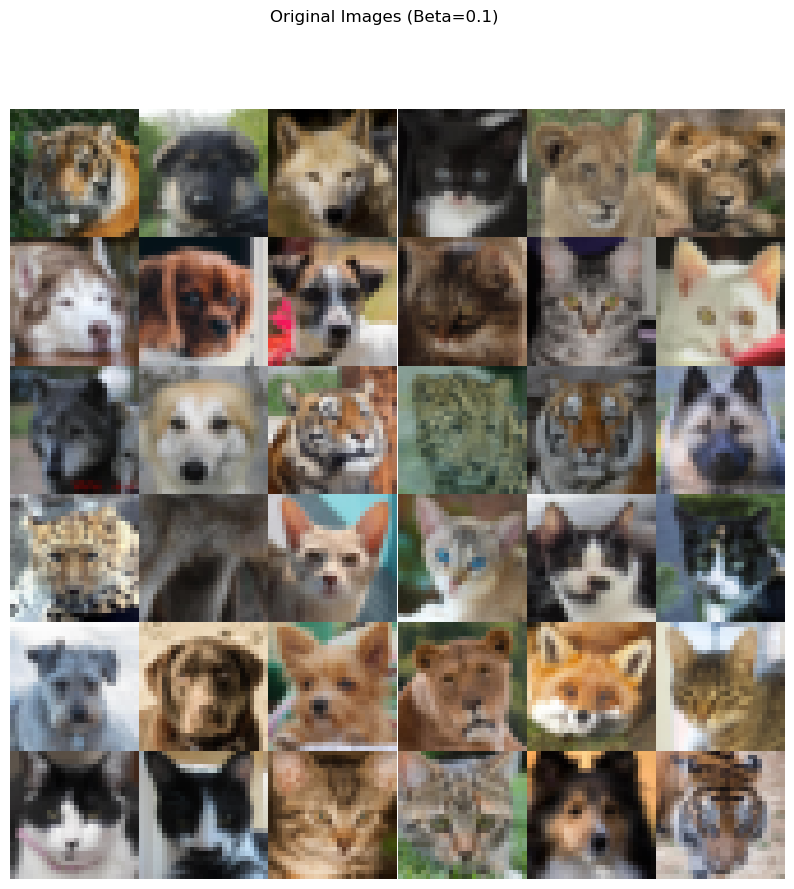

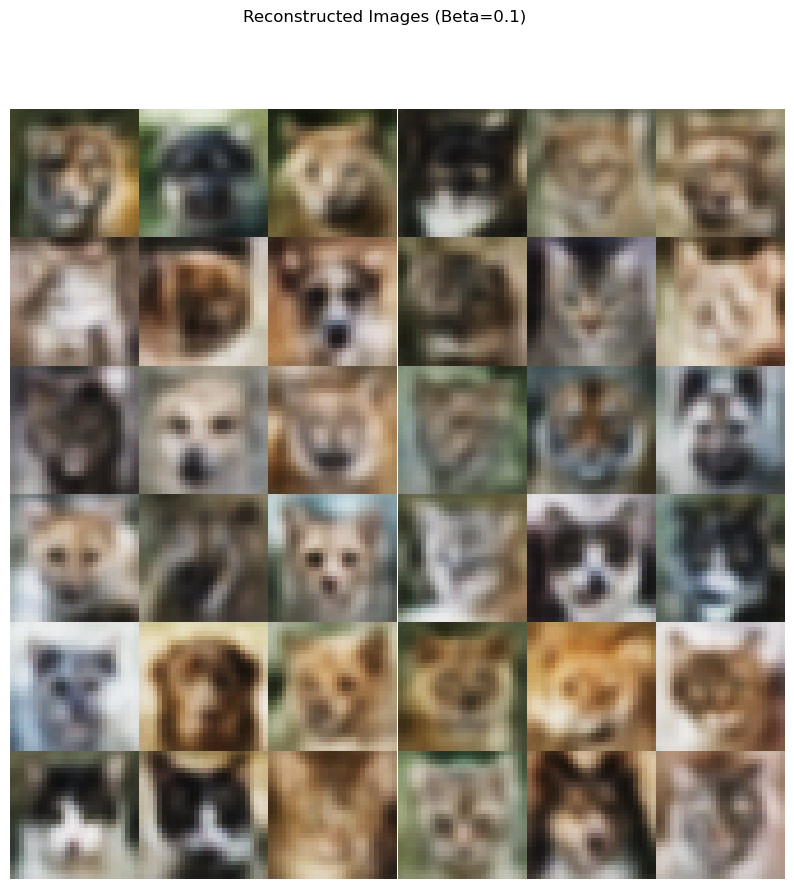

Epoch [1/10] Beta: 0.5, Total Loss: 62.36536929481908, MSE Loss: 47.68323396381579, KL Loss: 29.364267449629935
Epoch [2/10] Beta: 0.5, Total Loss: 56.114591899671055, MSE Loss: 41.853098016036185, KL Loss: 28.522987767269736
Epoch [3/10] Beta: 0.5, Total Loss: 51.949636358963815, MSE Loss: 37.78015457956415, KL Loss: 28.338966771175986
Epoch [4/10] Beta: 0.5, Total Loss: 47.73476048519737, MSE Loss: 33.1009521484375, KL Loss: 29.267616673519736
Epoch [5/10] Beta: 0.5, Total Loss: 48.12111302425987, MSE Loss: 34.01787045127467, KL Loss: 28.20648193359375
Epoch [6/10] Beta: 0.5, Total Loss: 53.46968158922697, MSE Loss: 39.15281596936678, KL Loss: 28.633731239720394
Epoch [7/10] Beta: 0.5, Total Loss: 54.99510433799342, MSE Loss: 39.35675048828125, KL Loss: 31.27671412417763
Epoch [8/10] Beta: 0.5, Total Loss: 46.86273193359375, MSE Loss: 31.940359015213815, KL Loss: 29.84474583675987
Epoch [9/10] Beta: 0.5, Total Loss: 50.309541401110195, MSE Loss: 35.4656404194079, KL Loss: 29.68780196

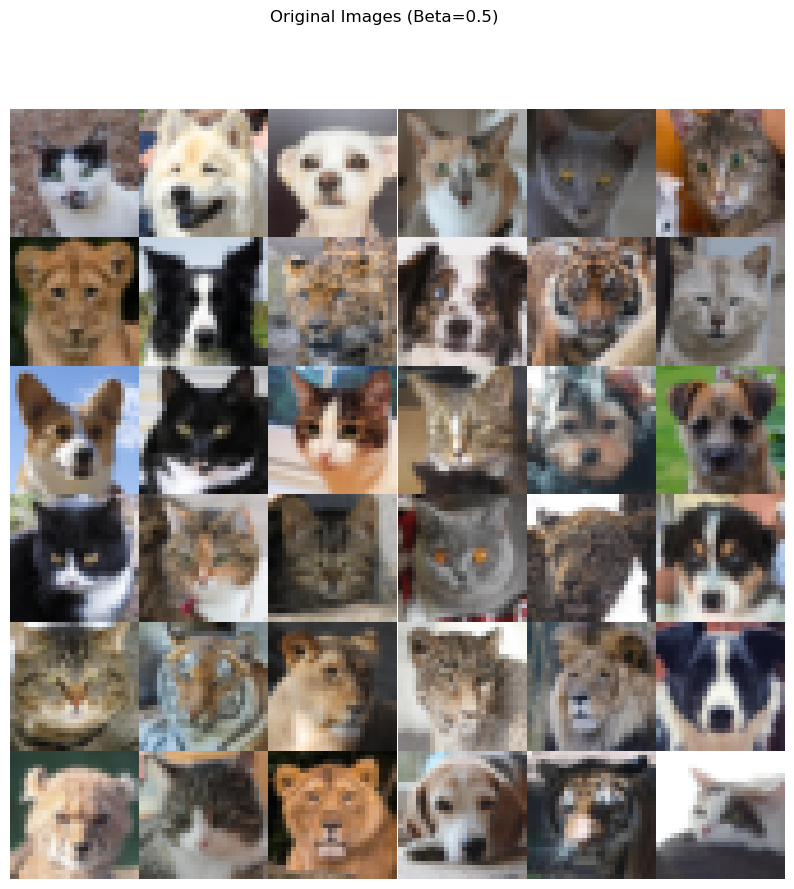

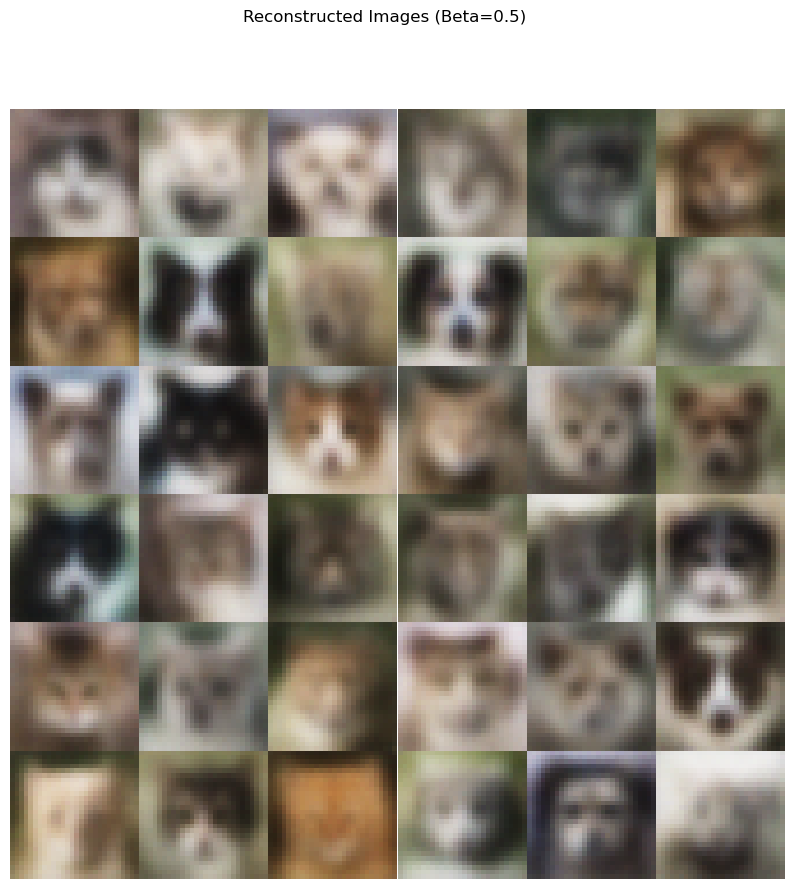

Epoch [1/10] Beta: 1.5, Total Loss: 82.27009020353618, MSE Loss: 62.9192537006579, KL Loss: 12.900557668585526
Epoch [2/10] Beta: 1.5, Total Loss: 71.32656378495066, MSE Loss: 54.53078099300987, KL Loss: 11.197188527960526
Epoch [3/10] Beta: 1.5, Total Loss: 73.73954050164474, MSE Loss: 55.429289165296055, KL Loss: 12.20683368883635
Epoch [4/10] Beta: 1.5, Total Loss: 66.07000411184211, MSE Loss: 49.89686986019737, KL Loss: 10.782091642680921
Epoch [5/10] Beta: 1.5, Total Loss: 70.66695363898026, MSE Loss: 54.142822265625, KL Loss: 11.016089991519326
Epoch [6/10] Beta: 1.5, Total Loss: 69.7760074013158, MSE Loss: 52.43361302425987, KL Loss: 11.56159892835115
Epoch [7/10] Beta: 1.5, Total Loss: 66.59274773848684, MSE Loss: 47.68147679379112, KL Loss: 12.607513427734375
Epoch [8/10] Beta: 1.5, Total Loss: 65.71678402549342, MSE Loss: 48.83485171669408, KL Loss: 11.254621003803454
Epoch [9/10] Beta: 1.5, Total Loss: 64.82256116365132, MSE Loss: 48.36533717105263, KL Loss: 10.9714829294305

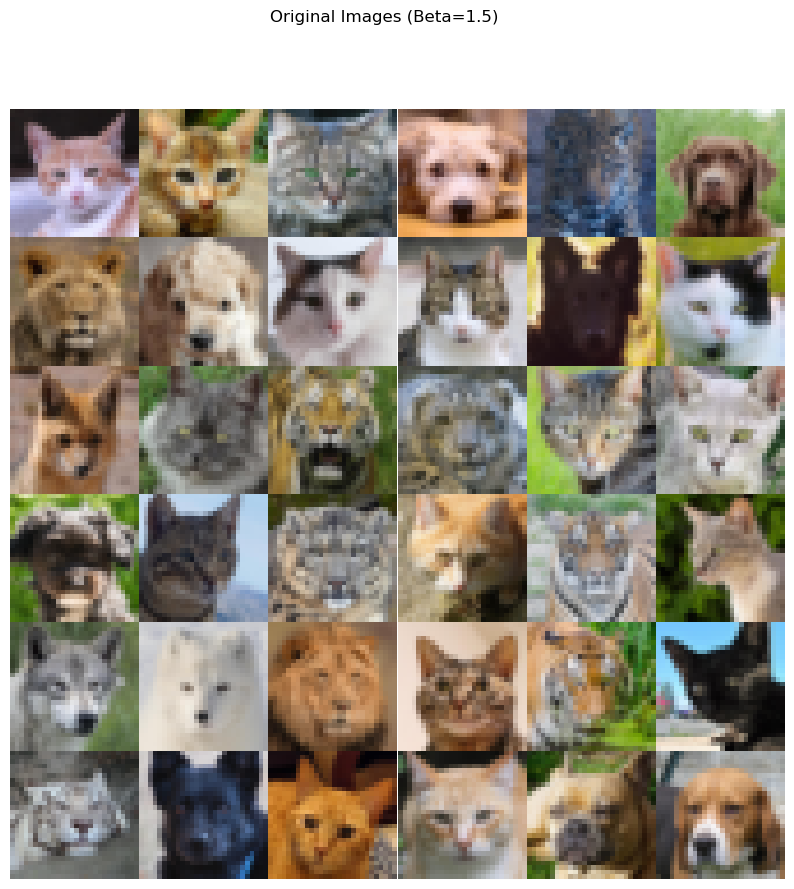

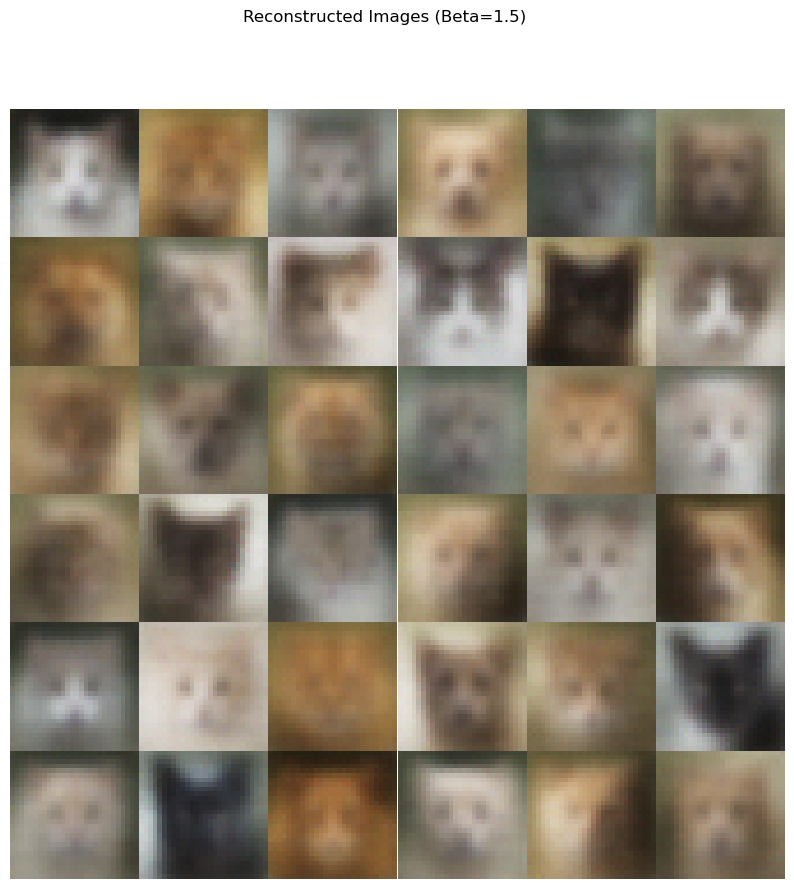

Epoch [1/10] Beta: 2.0, Total Loss: 84.00237715871711, MSE Loss: 65.04985608552632, KL Loss: 9.476260536595396
Epoch [2/10] Beta: 2.0, Total Loss: 78.75055895353618, MSE Loss: 60.48844829358553, KL Loss: 9.131055329975329
Epoch [3/10] Beta: 2.0, Total Loss: 73.31688168174342, MSE Loss: 54.39973530016447, KL Loss: 9.458573190789474
Epoch [4/10] Beta: 2.0, Total Loss: 76.52862870065789, MSE Loss: 58.728361430921055, KL Loss: 8.90013283177426
Epoch [5/10] Beta: 2.0, Total Loss: 78.06294973273026, MSE Loss: 58.2510408100329, KL Loss: 9.905956067537007
Epoch [6/10] Beta: 2.0, Total Loss: 77.80232319078948, MSE Loss: 58.25931589226974, KL Loss: 9.77150525544819
Epoch [7/10] Beta: 2.0, Total Loss: 80.45027883429276, MSE Loss: 61.3943513569079, KL Loss: 9.527962935598273
Epoch [8/10] Beta: 2.0, Total Loss: 75.61060855263158, MSE Loss: 57.12595086348684, KL Loss: 9.24233045076069
Epoch [9/10] Beta: 2.0, Total Loss: 72.80742444490132, MSE Loss: 54.60463353207237, KL Loss: 9.101396259508634
Epoch

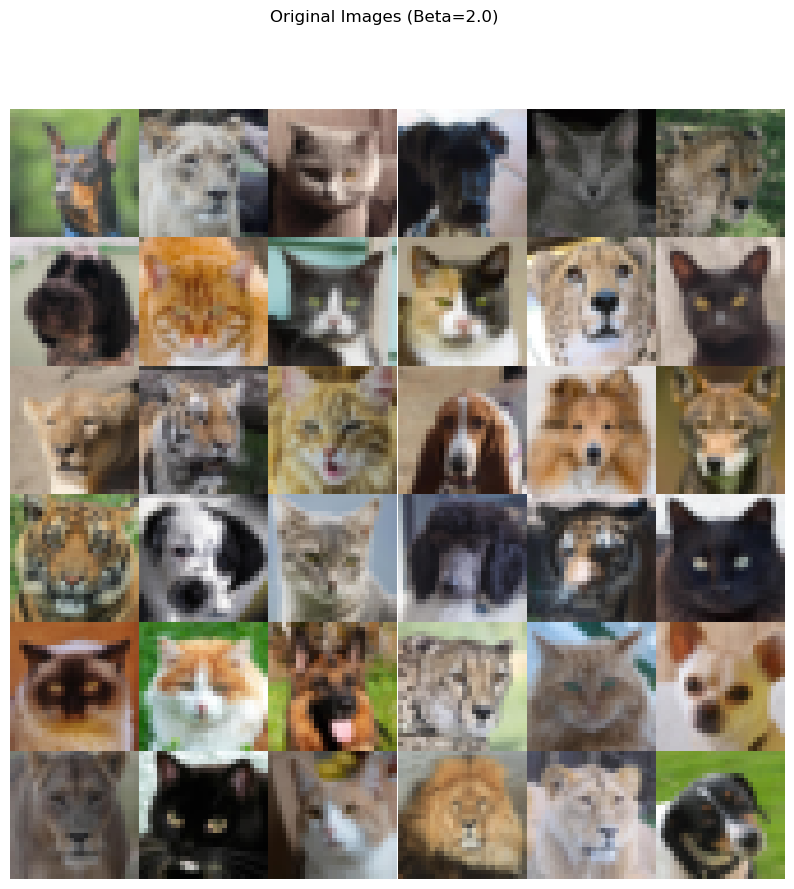

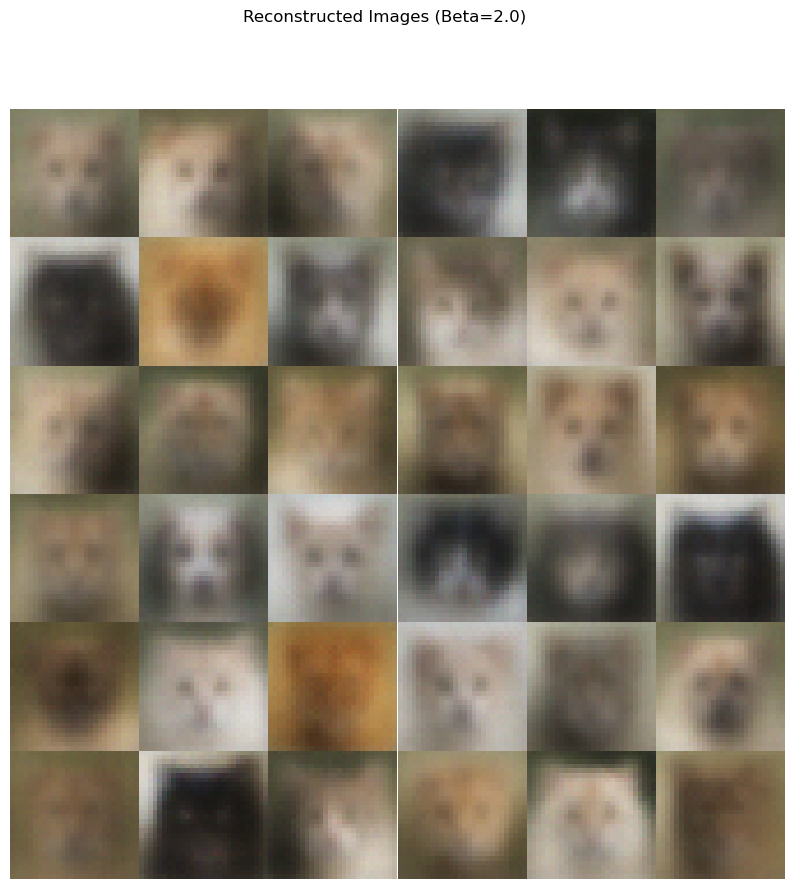

In [67]:

beta_values = [0.1, 0.5, 1.5, 2.0]
NUM_EPOCHS = 10
LATENT_DIM = 128

# Define your loss function outside of the training loop
def loss_function(recon_x, x, mu, logvar, beta):
    # Likelihood term (MSE)
    MSE = nn.MSELoss(reduction='sum')
    mse_loss = MSE(recon_x, x)

    # KL divergence term
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combined loss
    loss = mse_loss +  beta * kld_loss  

    return loss, mse_loss, kld_loss

# Function to train and save a VAE for a specific beta value
def train_and_save_vae(beta,train_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE().to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    
    vae.train()
    for epoch in range(NUM_EPOCHS):
        for batch_idx, (data, _) in enumerate(train_dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss, mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Beta: {beta}, Total Loss: {loss.item() / len(data)}, MSE Loss: {mse_loss.item() / len(data)}, KL Loss: {kld_loss.item() / len(data)}")
    torch.save(vae.state_dict(), f"vae_model_beta{beta}.pt")
    vae.eval()
    with torch.no_grad():
        for i in range(10):
            z = torch.randn(128, LATENT_DIM).to(device)
            generated_images = vae.decode(z)
            save_image(generated_images.view(128, 3, 28, 28), f"Generated_samples_{i}_beta{beta}.png", nrow=10, normalize=True)

    # Load and display the first 100 original images
    plot_grid(data[:100], f"Original Images (Beta={beta})")

    # Load and display the first 100 reconstructed images
    plot_grid(recon_batch[:100], f"Reconstructed Images (Beta={beta})")

# Loop through different beta values and train/save a VAE for each
for beta in beta_values:
    train_and_save_vae(beta, train_dataloader)


In [68]:
model_filename = f"vae_model_beta{0.1}.pt"  # Replace with the actual filename
vae = VAE()  # Create an instance of the VAE
vae.load_state_dict(torch.load(model_filename))
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SELU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SELU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=3136, out_features=512, bias=True)
    (7): SELU()
    (8): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SELU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): SELU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): SELU()
    (7): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

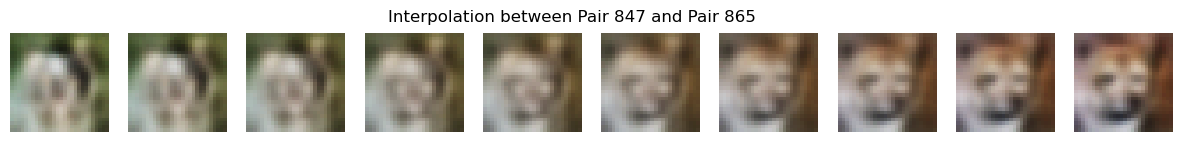

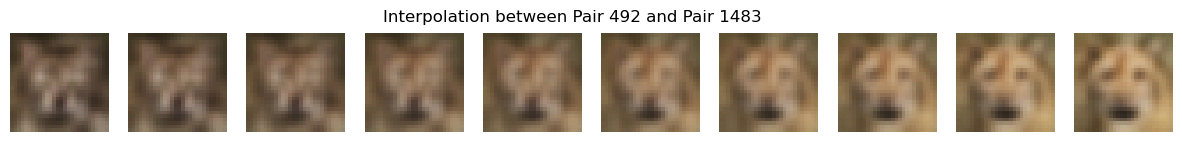

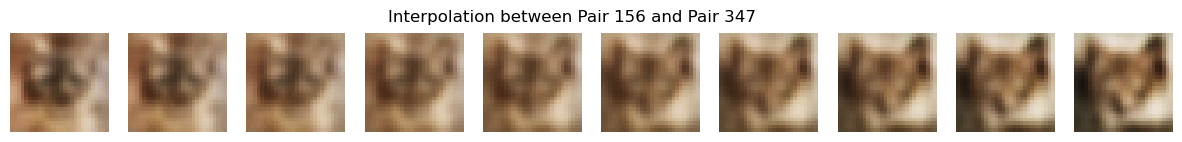

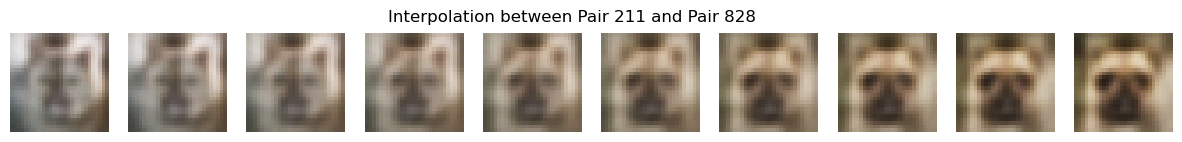

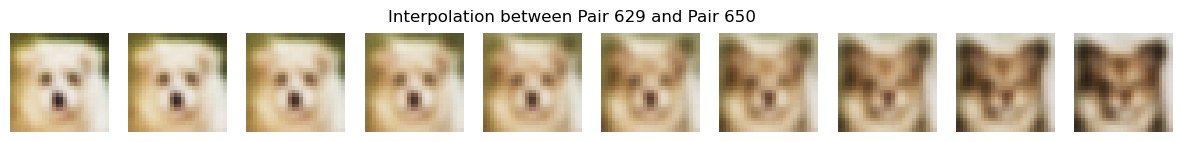

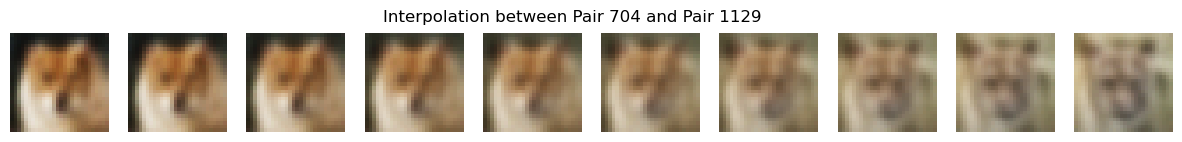

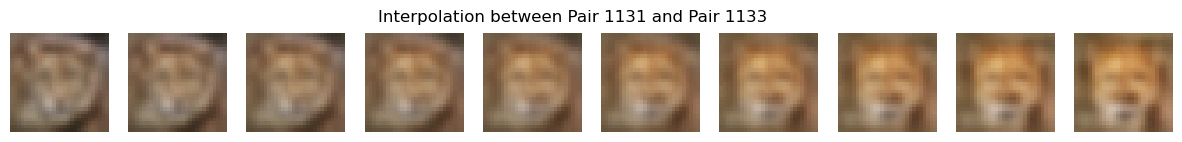

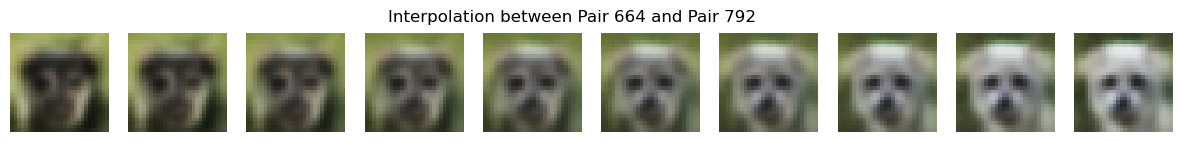

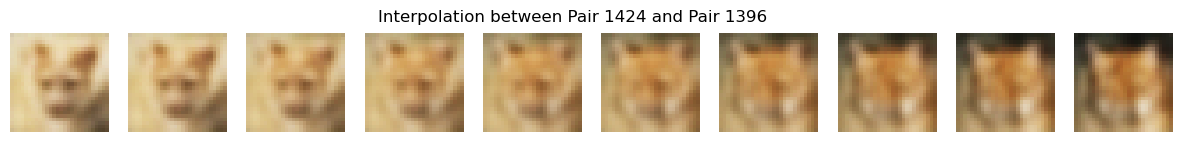

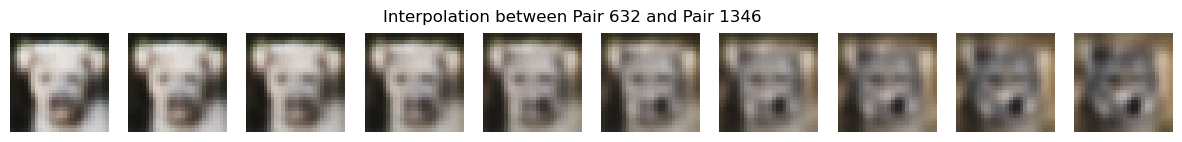

In [79]:
num_interpolations = 10
num_pairs = 10
latent_dim = 128
pair_indices = torch.randint(0, len(val_dataset), (num_pairs, 2))

for pair_index in pair_indices:
    image1 = val_dataset[pair_index[0]][0]  # Assuming your dataset returns (image, label), get the image
    image2 = val_dataset[pair_index[1]][0]

    with torch.no_grad():
        _, mu1, log_var1 = vae(image1.unsqueeze(0))
        _, mu2, log_var2 = vae(image2.unsqueeze(0))
        latent1 = vae.reparameterize(mu1, log_var1)
        latent2 = vae.reparameterize(mu2, log_var2)

    
    interpolated_latents = torch.stack([(1 - alpha) * latent1 + alpha * latent2 for alpha in torch.linspace(0, 1, num_interpolations)])

    with torch.no_grad():
        interpolated_images = vae.decoder(interpolated_latents.view(-1, latent_dim))  # Reshape interpolated_latents

    
    plt.figure(figsize=(15, 1.5))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, num_interpolations, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert to numpy and permute the dimensions
        plt.axis('off')

    plt.suptitle(f'Interpolation between Pair {pair_index[0]} and Pair {pair_index[1]}')
    plt.show()




In [ ]:
#Auto Encoder


In [14]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.distributions as dist
import matplotlib.pyplot as plt

import numpy as np
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root="./afhq/train", transform=transform)
val_dataset = ImageFolder(root="./afhq/val", transform=transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1024,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1024,
    shuffle=True,
    num_workers=4
)



In [4]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(128*128*3, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128 * 128*3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [5]:

epochs = 20
learning_rate = 1e-3

In [6]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [8]:
loss_ep = []
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dataloader:
        
        # load it to the active device
        batch_features = batch_features.view(-1, 128*128*3).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, latent = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_dataloader)
    
    loss_ep.append(loss)
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))


epoch : 1/20, recon loss = 0.05143937
epoch : 2/20, recon loss = 0.04690266
epoch : 3/20, recon loss = 0.04295802
epoch : 4/20, recon loss = 0.03870081
epoch : 5/20, recon loss = 0.03632419
epoch : 6/20, recon loss = 0.03464308
epoch : 7/20, recon loss = 0.03456834
epoch : 8/20, recon loss = 0.03327558
epoch : 9/20, recon loss = 0.03257119
epoch : 10/20, recon loss = 0.03429110
epoch : 11/20, recon loss = 0.03354782
epoch : 12/20, recon loss = 0.03243078
epoch : 13/20, recon loss = 0.03187452
epoch : 14/20, recon loss = 0.03108711
epoch : 15/20, recon loss = 0.03116215
epoch : 16/20, recon loss = 0.03052039
epoch : 17/20, recon loss = 0.03019282
epoch : 18/20, recon loss = 0.03011912
epoch : 19/20, recon loss = 0.02998228
epoch : 20/20, recon loss = 0.02971963


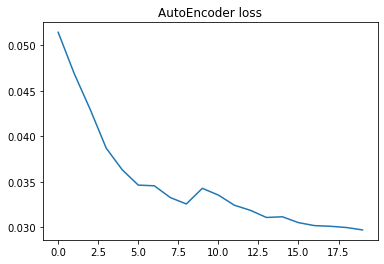

In [9]:
plt.figure()
plt.title('AutoEncoder loss')
plt.plot(loss_ep)
plt.show()

In [15]:
def get_latent_vector(model, dataloader, device):
    model.eval()  
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for images, labels_batch in dataloader:
            images = images.view(-1, 128*128*3).to(device)
            reconstruction, latent = model(images)  
#             z = vae.reparameterize(mu, log_var)  
            latent_vectors.append(latent.cpu().numpy())
            labels.append(labels_batch.numpy())
    
    # Concatenate the latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_vectors, labels


In [16]:
train_latent_vectors, train_labels = get_latent_vector(model, train_dataloader, device)
val_latent_vectors, val_labels = get_latent_vector(model, val_dataloader, device)

In [36]:
LATENT_DIM=32


(14630, 32)


In [17]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

In [18]:
input_dim = train_latent_vectors.shape[1]
hidden_dim = 128
output_dim = 3

In [19]:
classifier = MLPClassifier(input_dim, hidden_dim, output_dim)
classifier.to(device)


criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [26]:

num_classes = len(np.unique(train_dataset.targets))   
output_dim = 3 
mlp_cls = MLPClassifier(LATENT_DIM, num_classes,output_dim)
mlp_cls.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_cls.parameters(), lr=0.001)
train_losses = []
val_losses = []
val_accuracies = []
patience = 5
best_val_loss = float('inf')
counter = 0
num_epochs = 20
batch_size=512



In [27]:
train_dataloader_length = len(train_labels)
for epoch in range(num_epochs):
    mlp_cls.train()
    total_train_loss = 0.0
    train = torch.utils.data.TensorDataset(torch.tensor(train_latent_vectors, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
    train_load = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    for inputs, labels in train_load:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_cls(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    average_train_loss = total_train_loss / len(train_load)

    
    mlp_cls.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        val = torch.utils.data.TensorDataset(torch.tensor(val_latent_vectors, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
        val_load = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

        for inputs, labels in val_load:
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = mlp_cls(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(val_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    average_val_loss = total_val_loss / len(val_load)
    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered.")
        break
final_val_accuracy = val_accuracy

print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Epoch 1/20, Train Loss: 1.1336, Val Loss: 1.1201, Val Accuracy: 33.33%
Epoch 2/20, Train Loss: 1.1246, Val Loss: 1.1107, Val Accuracy: 33.33%
Epoch 3/20, Train Loss: 1.1141, Val Loss: 1.1005, Val Accuracy: 33.33%
Epoch 4/20, Train Loss: 1.1026, Val Loss: 1.0897, Val Accuracy: 33.33%
Epoch 5/20, Train Loss: 1.0904, Val Loss: 1.0773, Val Accuracy: 33.33%
Epoch 6/20, Train Loss: 1.0764, Val Loss: 1.0641, Val Accuracy: 33.33%
Epoch 7/20, Train Loss: 1.0630, Val Loss: 1.0515, Val Accuracy: 48.27%
Epoch 8/20, Train Loss: 1.0522, Val Loss: 1.0411, Val Accuracy: 49.53%
Epoch 9/20, Train Loss: 1.0388, Val Loss: 1.0269, Val Accuracy: 53.20%
Epoch 10/20, Train Loss: 1.0147, Val Loss: 1.0002, Val Accuracy: 50.00%
Epoch 11/20, Train Loss: 0.9844, Val Loss: 0.9815, Val Accuracy: 47.87%
Epoch 12/20, Train Loss: 0.9653, Val Loss: 0.9644, Val Accuracy: 49.53%
Epoch 13/20, Train Loss: 0.9524, Val Loss: 0.9557, Val Accuracy: 50.00%
Epoch 14/20, Train Loss: 0.9449, Val Loss: 0.9483, Val Accuracy: 51.53%
E

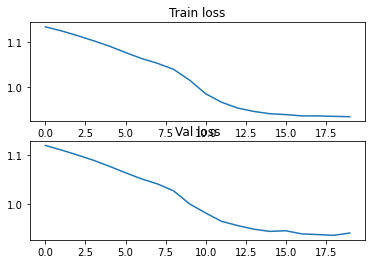

In [28]:
train_loss = [1.1336, 1.1246, 1.1141, 1.1026, 1.0904, 1.0764, 1.0630, 1.0522, 1.0388, 1.0147, 0.9844, 0.9653, 0.9524, 0.9449, 0.9398, 0.9378, 0.9349, 0.9349, 0.9339, 0.9331]

val_loss = [1.1201, 1.1107, 1.1005, 1.0897, 1.0773, 1.0641, 1.0515, 1.0411, 1.0269, 1.0002, 0.9815, 0.9644, 0.9557, 0.9483, 0.9437, 0.9451, 0.9386, 0.9372, 0.9357, 0.9404]


plt.figure()
plt.subplot(2,1,1)
plt.plot(train_loss)
plt.title('Train loss')
plt.subplot(2,1,2)
plt.plot(val_loss)
plt.title('Val loss')
plt.show()

torch.Size([1024, 32])


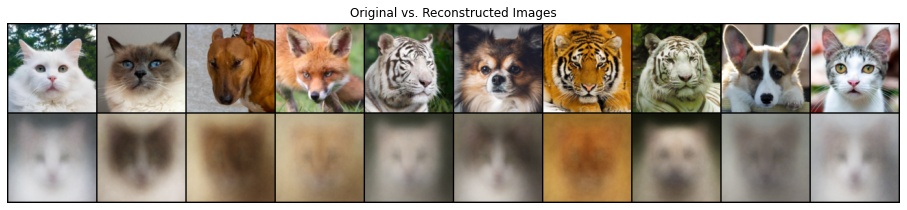

In [72]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to plot original and reconstructed images side by side
def plot_original_reconstructed(model,val_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_iter = iter(val_dataloader)
        data, _ = next(data_iter)
        data = data.view(-1, 128*128*3).to(device)
        
        # Reconstruct the data
        recon_batch, lat = model(data)
        print(lat.shape)
        
        # Create a grid of original and reconstructed images
        combined_images = torch.cat([data.reshape(-1,3,128,128)[:10], recon_batch.reshape(-1,3,128,128)[:10]])
        
        # Plot the grid of images
        plt.figure(figsize=(16, 10))
        plt.axis("off")
        plt.title("Original vs. Reconstructed Images")
        plt.imshow(vutils.make_grid(combined_images, nrow=10, normalize=True).cpu().numpy().transpose(1, 2, 0))
        plt.show()

# Call the function to plot original and reconstructed images
plot_original_reconstructed(model, val_dataloader, device)

In [73]:
import numpy as np
# !python -m pip install -U scikit-learn
from sklearn.mixture import GaussianMixture

import pandas as pd

gm = GaussianMixture(n_components=10, verbose=2, verbose_interval=1)


In [74]:
gm.fit(train_latent_vectors)


Initialization 0
  Iteration 1	 time lapse 0.47444s	 ll change inf
  Iteration 2	 time lapse 0.18311s	 ll change 10.79751
  Iteration 3	 time lapse 0.18345s	 ll change 4.14170
  Iteration 4	 time lapse 0.18257s	 ll change 2.44863
  Iteration 5	 time lapse 0.18340s	 ll change 2.13001
  Iteration 6	 time lapse 0.18431s	 ll change 1.68560
  Iteration 7	 time lapse 0.18201s	 ll change 0.81943
  Iteration 8	 time lapse 0.18106s	 ll change 0.52376
  Iteration 9	 time lapse 0.16032s	 ll change 0.54150
  Iteration 10	 time lapse 0.16157s	 ll change 0.37496
  Iteration 11	 time lapse 0.16118s	 ll change 0.23393
  Iteration 12	 time lapse 0.16043s	 ll change 0.31018
  Iteration 13	 time lapse 0.16013s	 ll change 0.36466
  Iteration 14	 time lapse 0.16040s	 ll change 0.35659
  Iteration 15	 time lapse 0.19075s	 ll change 0.29410
  Iteration 16	 time lapse 0.18768s	 ll change 0.21824
  Iteration 17	 time lapse 0.18167s	 ll change 0.15022
  Iteration 18	 time lapse 0.19980s	 ll change 0.09935
  Ite

GaussianMixture(n_components=10, verbose=2, verbose_interval=1)

In [75]:
new_sample = gm.sample(n_samples=100)

In [94]:
new_sample[0].shape

print(torch.tensor(new_sample[0][0,:]))
model.eval()
model.decoder(torch.tensor(new_sample[0]).float().to(device))
# model.decoder(torch.tensor(new_sample[0][0]).double().to(device))

tensor([ -5.2813,   4.5479,   0.7885,   0.5642,  -1.4328,   4.0967,   1.3330,
         19.2724,  -1.0714,   4.3893,   6.3156,  -1.7978,  10.3813, -12.9462,
          1.1828,   5.1375,   5.1681,  -4.5815,   4.4224,  -0.4821,   4.2529,
         -1.2605,  -1.0784,  12.1684,   6.2632,  -0.2739,   9.8985,  -1.5033,
          2.7852,  -5.3723,  -1.2555,  -3.7620], dtype=torch.float64)


tensor([[0.8591, 0.8666, 0.8585,  ..., 0.1315, 0.1283, 0.1332],
        [0.5492, 0.5630, 0.5576,  ..., 0.1790, 0.1840, 0.1882],
        [0.8088, 0.8115, 0.8126,  ..., 0.3593, 0.3562, 0.3610],
        ...,
        [0.5183, 0.5095, 0.5224,  ..., 0.2705, 0.2767, 0.2740],
        [0.3148, 0.3103, 0.3141,  ..., 0.3637, 0.3762, 0.3673],
        [0.4304, 0.4366, 0.4400,  ..., 0.1327, 0.1256, 0.1259]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

torch.Size([100, 32])


/data3/rishubh/anaconda3/envs/badrinath_adrl/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


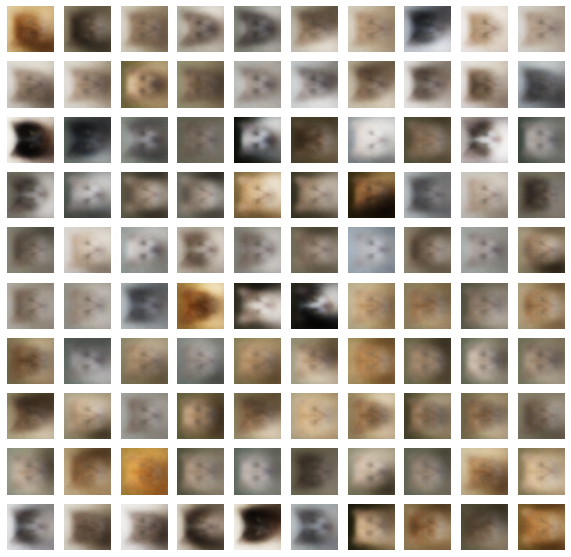

In [105]:
from torchvision.utils import save_image

# for sample in new_sample[0]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    data = torch.tensor(new_sample[0]).view(-1, 32).to(device)
    print(data.shape)
    # Reconstruct the data
    recon_batch = model.decoder(torch.tensor(data).float().to(device))
    
    save_image(recon_batch.view(100, 3,128,128), './autoencoder_sample.png')

    # Create a grid of original and reconstructed images
#         combined_images = torch.cat([recon_batch.reshape(-1,3,128,128)[:10]])

    # Plot the grid of images

    fig, axs = plt.subplots(10, 10, figsize=(10,10))

    for i,d in enumerate(recon_batch.view(100,3,128,128)):
        r, c = int(i/10), int(i%10)
        # print(r,c)

        # print(d.shape, np.expand_dims(d,axis=1).shape)
        # for j in range(10):
        axs[r,c].imshow(d.cpu().permute(2,1,0) )#np.expand_dims(d,axis=1))#.reshape((28,28)))
        axs[r,c].axis('off')


        
#         plt.figure(figsize=(10, 10))
#         plt.axis("off")
#         plt.title("Original vs. Reconstructed Images")
#         plt.imshow(vutils.make_grid(combined_images, nrow=10, normalize=True).cpu().numpy().transpose(1, 2, 0))
#         plt.show()